# Thinkful Capstone Final Project : Exploration

### Roy Shabaya

# Overview

For my final project I will be building a recommender system for an online retailer.  The overall problem I am attempting to solve is to be able to provide meaningful and high quality recommendations to customers.  The dataset is downloaded from UCI’s Machine Learning Repository and contains transaction data from an online retailer based in the UK.  The retailer sells gift items across several countries in Europe.  Contained in the data is information on each transaction, including the customer and product purchased.  In such a setting a recommender system can allow a retailer to provide quality recommendations to the customer that can result in increased sales and customer satisfaction.  

Data Source : https://archive.ics.uci.edu/ml/datasets/Online+Retail

## Index

[Data Import and Pre-Processing](#Data)

[Exploration](#exploration_link)
   - [Time](#time_link)
   - [Customer](#customer_link)
   - [Transaction](#transaction_link)
   - [Product](#product_link)
   
<a id='Data'></a>

## Data Import and Pre-processing

In [1]:
# Import necessary packages
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import date
import calendar

In [2]:
# Import data
data = pd.read_csv(r'C:\Users\shaba\Online Retail.csv')

In [3]:
# See columns and their data type information.  Date is an object, will need to be modified at least for time series
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 541909 entries, 0 to 541908
Data columns (total 8 columns):
InvoiceNo      541909 non-null object
StockCode      541909 non-null object
Description    540455 non-null object
Quantity       541909 non-null int64
InvoiceDate    541909 non-null object
UnitPrice      541909 non-null float64
CustomerID     406829 non-null float64
Country        541909 non-null object
dtypes: float64(2), int64(1), object(5)
memory usage: 33.1+ MB


In [4]:
data['InvoiceDate'] = pd.to_datetime(data['InvoiceDate'])

In [5]:
# See the first 5 rows of data
data.head()

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,2010-12-01 08:26:00,2.55,17850.0,United Kingdom
1,536365,71053,WHITE METAL LANTERN,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,2010-12-01 08:26:00,2.75,17850.0,United Kingdom
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom


In [6]:
# Add a revenue column, multiplying quanity and unit price. Also exclude returns and focus on sales only
data = data.loc[(data['Quantity'] >0) & (data['UnitPrice'] >0)]
data["Revenue"] = data['Quantity'] * data['UnitPrice']

In [7]:
# Add several views of the date information, Day of Week, Hour, etc.
data['Day of Week'] = data["InvoiceDate"].dt.weekday_name
data['Week of Year'] = data["InvoiceDate"].dt.weekofyear
data['Week of Year'] = data["InvoiceDate"].dt.weekofyear
data['Month'] = data["InvoiceDate"].dt.month
data['Hour'] = data["InvoiceDate"].dt.hour
data['Year'] = data["InvoiceDate"].dt.year
data['Day of Week Number'] = data['InvoiceDate'].dt.weekday

In [8]:
# See head with additional columns added
data.head()

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country,Revenue,Day of Week,Week of Year,Month,Hour,Year,Day of Week Number
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,2010-12-01 08:26:00,2.55,17850.0,United Kingdom,15.30,Wednesday,48,12,8,2010,2
1,536365,71053,WHITE METAL LANTERN,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom,20.34,Wednesday,48,12,8,2010,2
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,2010-12-01 08:26:00,2.75,17850.0,United Kingdom,22.00,Wednesday,48,12,8,2010,2
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom,20.34,Wednesday,48,12,8,2010,2
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom,20.34,Wednesday,48,12,8,2010,2


<a id='exploration_link'></a>

# Exploration
<a id='time_link'></a>

## Time Exploration

In [9]:
print("data start: {}".format(data.InvoiceDate.min()))
print("data end: {}".format(data.InvoiceDate.max()))

data start: 2010-12-01 08:26:00
data end: 2011-12-09 12:50:00


In [10]:
#Regroup sales transactions
twelve_month_data = data.loc[data['InvoiceDate'] < '2011-12-01']
sales_time_grouped = data.groupby(['InvoiceNo','Day of Week','Week of Year','Month',"Hour",'Year','Day of Week Number'], as_index=False)['Quantity','Revenue'].sum()
sales_time_grouped_12 = twelve_month_data.groupby(['InvoiceNo','Day of Week','Week of Year','Month',"Hour",'Year','Day of Week Number'], as_index=False)['Quantity','Revenue'].sum()
sales_dow_grouped = data.groupby(['InvoiceNo','Day of Week Number','Day of Week'], as_index=False)['Quantity','Revenue'].sum()
time_grouped_75_revenue = sales_dow_grouped.loc[sales_time_grouped["Revenue"] < sales_dow_grouped.Revenue.quantile(.75)]
time_grouped_75_quantity = sales_time_grouped.loc[sales_time_grouped["Quantity"] < sales_time_grouped.Revenue.quantile(.75)]
time_grouped_75_quantity_12 = sales_time_grouped_12.loc[sales_time_grouped["Quantity"] < sales_time_grouped_12.Revenue.quantile(.75)]


#time_grouped_75_quantity = sales_time_grouped.loc[sales_time_grouped["Quantity"] < sales_time_grouped.Quantity.quantile(.75)]

dow_grouped_75_quantity = time_grouped_75_quantity.groupby(['Day of Week Number','Day of Week'], as_index=False)['Quantity'].sum()

woy_grouped_75_quantity = time_grouped_75_quantity_12.groupby(['Week of Year'], as_index=False)['Quantity'].sum()

hour_grouped_75_quantity = time_grouped_75_quantity.groupby(['Hour'], as_index=False)['Quantity'].sum()

year_grouped_75_quantity = time_grouped_75_quantity.groupby(['Year'], as_index=False)['Quantity'].sum()

month_grouped_75_quantity = time_grouped_75_quantity_12.groupby(['Month'], as_index=False)['Quantity'].sum()
#time_grouped_75_revenue = sales_time_grouped.loc[sales_trans_grou#

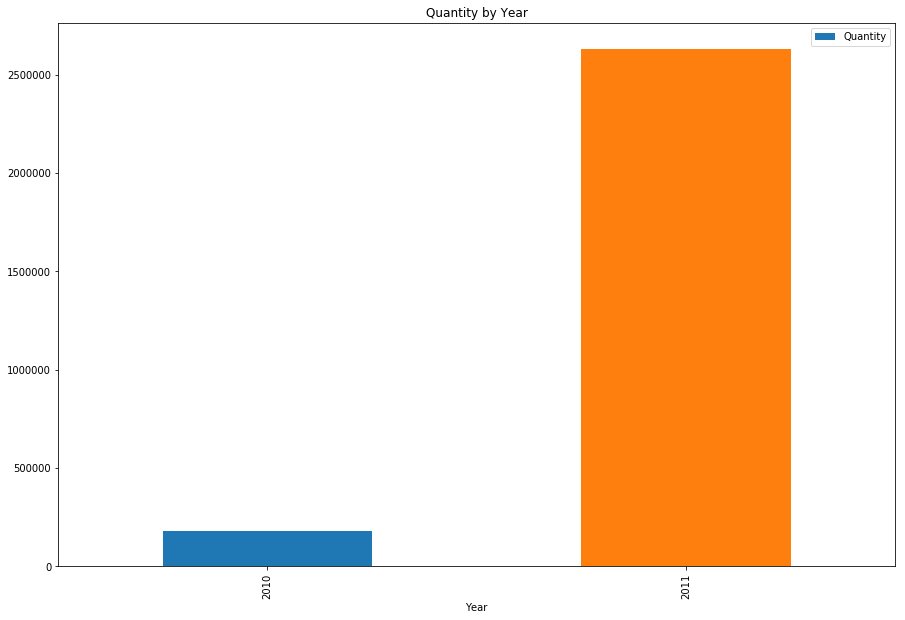

In [11]:
year_grouped_75_quantity.plot(x="Year", y='Quantity', kind='bar', figsize=(15,10))
plt.title('Quantity by Year')
plt.show()

It looks like there are only a few days in December 2019 included.  Will exclude December 2011 from the time exploration, will still have a few 12 months of data.

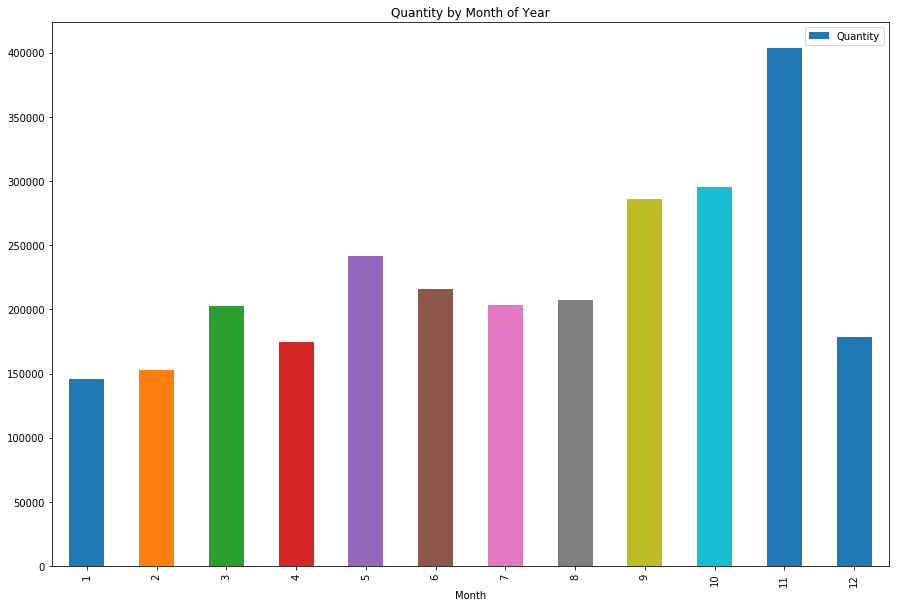

In [12]:
month_grouped_75_quantity.plot(x="Month", y='Quantity', kind='bar', figsize=(15,10))
plt.title('Quantity by Month of Year')
plt.show()

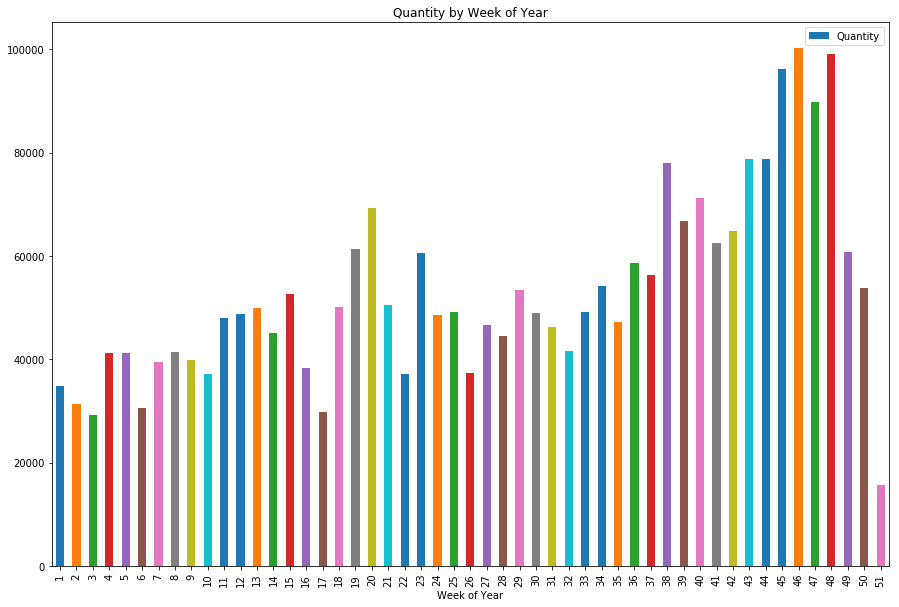

In [13]:
woy_grouped_75_quantity.plot(x="Week of Year", y='Quantity', kind='bar', figsize=(15,10))
plt.title('Quantity by Week of Year')
plt.show()

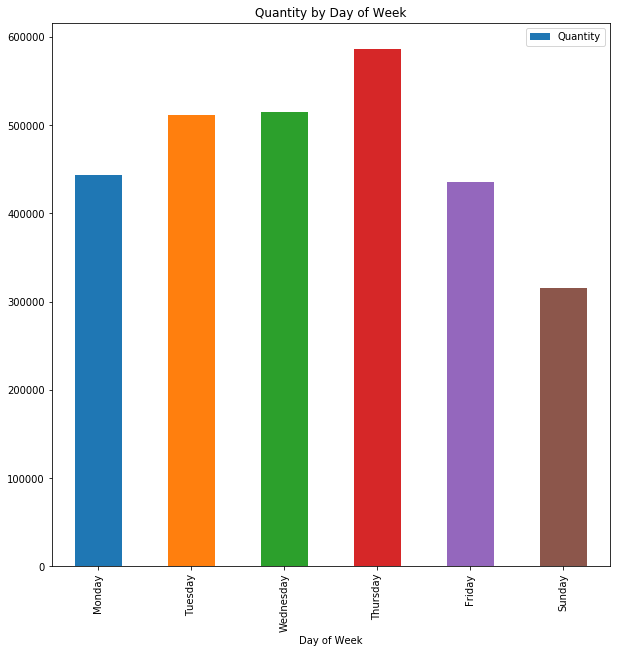

In [14]:
dow_grouped_75_quantity.plot(x="Day of Week", y='Quantity', kind='bar', figsize=(10,10))
plt.title('Quantity by Day of Week')
plt.show()

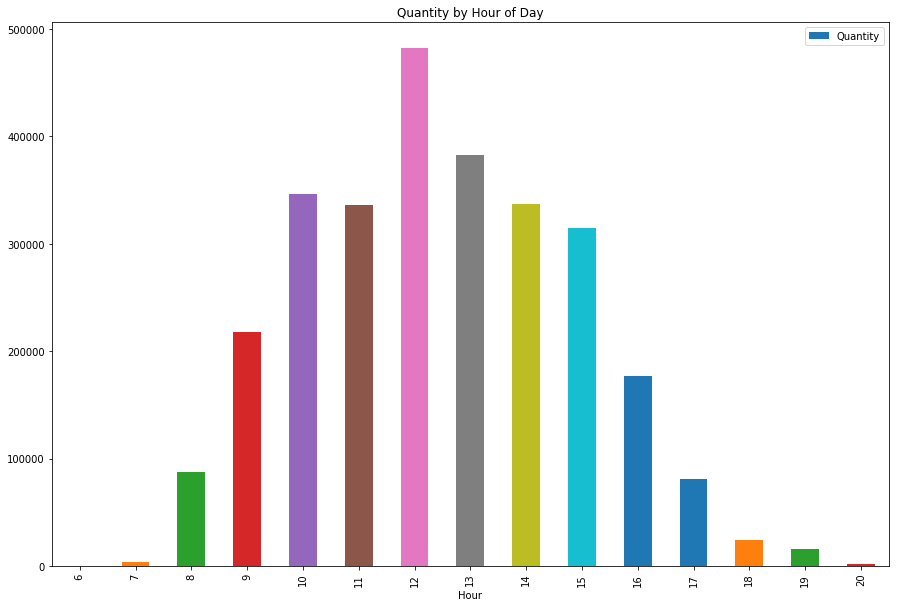

In [15]:
hour_grouped_75_quantity.plot(x="Hour", y='Quantity', kind='bar', figsize=(15,10))
plt.title('Quantity by Hour of Day')
plt.show()

<a id='customer_link'></a>

## Customer Exploration

In [16]:
#Regroup data at the customer level
sales_cust_grouped = data.groupby('CustomerID')['Quantity','Revenue'].sum()
sales_cust_grouped['ASP'] = sales_cust_grouped["Revenue"]/ sales_cust_grouped['Quantity']
print('Number of Customers: {}'.format(len(sales_cust_grouped)))

Number of Customers: 4338


In [17]:
# Descriptive statistics for the customer level data
sales_cust_grouped.describe()

,Quantity,Revenue,ASP
count,4338.000000,4338.000000,4338.000000
mean,1191.289073,2054.266460,3.013989
std,5046.081546,8989.230441,33.218307
min,1.000000,3.750000,0.085619
25%,160.000000,307.415000,1.408745
50%,379.000000,674.485000,1.808724
75%,992.750000,1661.740000,2.351760
max,196915.000000,280206.020000,2033.100000


In [77]:
sales_cust_grouped

,Quantity,Revenue,ASP
CustomerID,,,
12346.0,74215,77183.60,1.040000
12347.0,2458,4310.00,1.753458
12348.0,2341,1797.24,0.767723
12349.0,631,1757.55,2.785341
12350.0,197,334.40,1.697462
12352.0,536,2506.04,4.675448
12353.0,20,89.00,4.450000
12354.0,530,1079.40,2.036604
12355.0,240,459.40,1.914167


In [85]:
sales_cust_grouped = sales_cust_grouped.sort_values(by='Quantity', ascending=False)
top_10_customers = sales_cust_grouped.head(10).reset_index()
top_10_customers = top_10_customers.sort_values(by="Quantity", ascending=True)

In [86]:
sales_cust_grouped

,Quantity,Revenue,ASP
CustomerID,,,
14646.0,196915,280206.02,1.422980
16446.0,80997,168472.50,2.079984
14911.0,80265,143825.06,1.791878
12415.0,77374,124914.53,1.614425
12346.0,74215,77183.60,1.040000
17450.0,69993,194550.79,2.779575
17511.0,64549,91062.38,1.410748
18102.0,64124,259657.30,4.049300
13694.0,63312,65039.62,1.027287


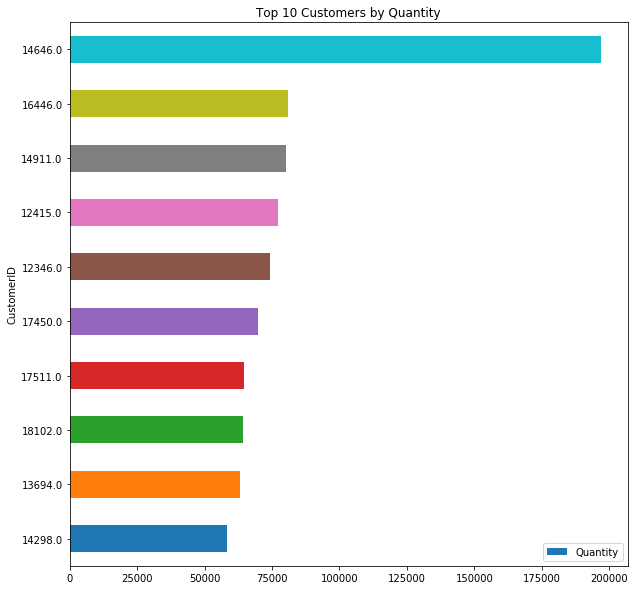

In [88]:
top_10_customers.plot(x='CustomerID',y='Quantity', kind='barh', figsize=(10,10))
plt.title("Top 10 Customers by Quantity")
plt.show()

First, we can see there are 4,318 customers. There are interesting gaps in the customers looking at the revenue alone.  The average customer has spent 1,1815, the smallest 2.90 and the biggest over 234,407.  It appears they have some large customers, but also service small customers as well.  The gaps in quantity are also similar, with the biggest customers purchasing over 156,113 units, versus a mean of 1,001 and 75th percentile of 939. Let's look at boxplots for ASP, Quanity and Revenue at the customer level.

We see there is a very large unit customers at 175,000 with the next customer at less than half that amount just above 75,000.  Let's look at how this is shown when we look at revenue.

Again, we see the very large customer with close to 250,000 in revenue.  It is interesting to note there are quite a few customers between 50,000 to 150,000.  And a bigger cluster in the lower thousands up to 50,000. Lets try to remove some of the larger customers by limiting units to the 75th percentile.  This should help us have a better understanding of the majority of the customers.

In [18]:
sales_cust_grouped.head()

,Quantity,Revenue,ASP
CustomerID,,,
12346.0,74215,77183.60,1.040000
12347.0,2458,4310.00,1.753458
12348.0,2341,1797.24,0.767723
12349.0,631,1757.55,2.785341
12350.0,197,334.40,1.697462


In [19]:
# Limit sales customer grouping to 940 units, 939 units is the 75th percentile.
sales_cust_grouped_75_qty = sales_cust_grouped.loc[sales_cust_grouped['Quantity'] < sales_cust_grouped.Quantity.quantile(.75)]
sales_cust_grouped_75_revenue = sales_cust_grouped.loc[sales_cust_grouped['Revenue'] < sales_cust_grouped.Revenue.quantile(.75)]

When we exclude some of the bigger customers we are still left from 3,237 customers, from our previous total of 4,318.  Interestingly this caps are biggest customer at 39,917 in revenue.  The average units ordered are 313 and 610 in revenue.  Let's look at histograms for distributions of these customers.

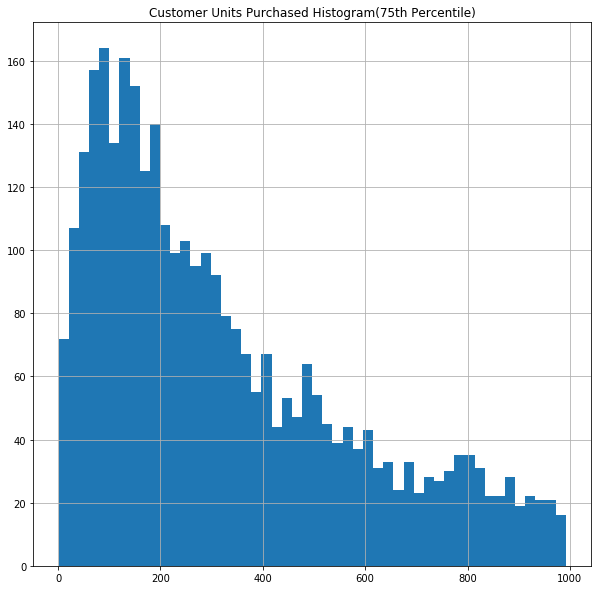

In [44]:
sales_cust_grouped_75_qty.hist(column='Quantity', bins=50, figsize=(10,10))
plt.title('Customer Units Purchased Histogram(75th Percentile)')
plt.show()

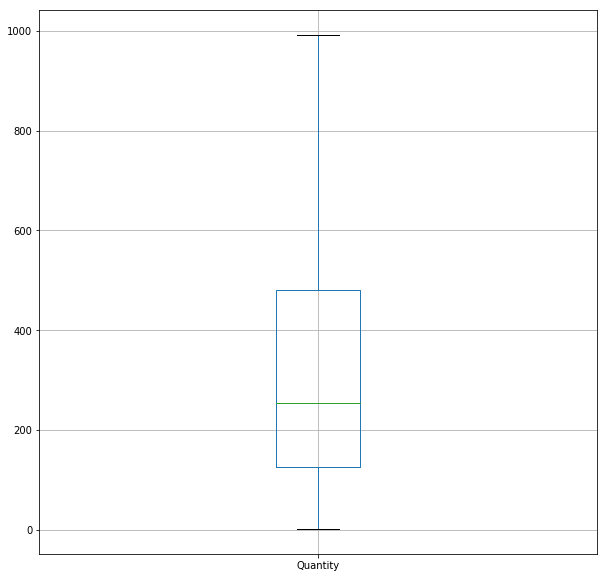

In [21]:
sales_cust_grouped_75_qty.boxplot(column='Quantity', figsize=(10,10))
plt.show()

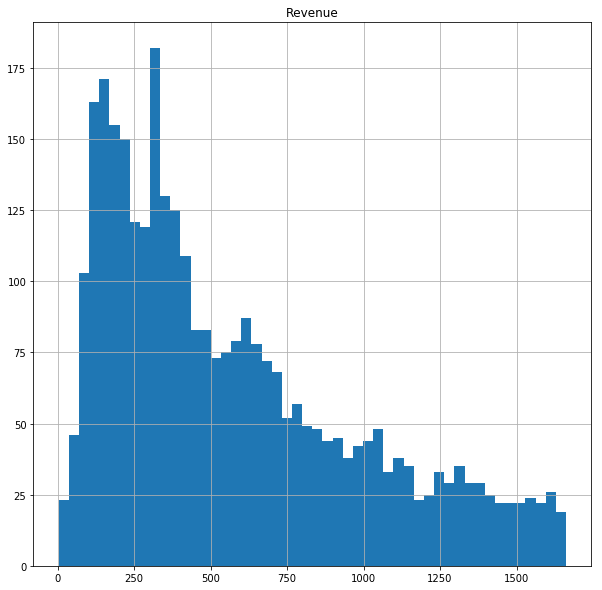

In [22]:
sales_cust_grouped_75_revenue.hist(column='Revenue', bins=50, figsize=(10,10))
plt.show()

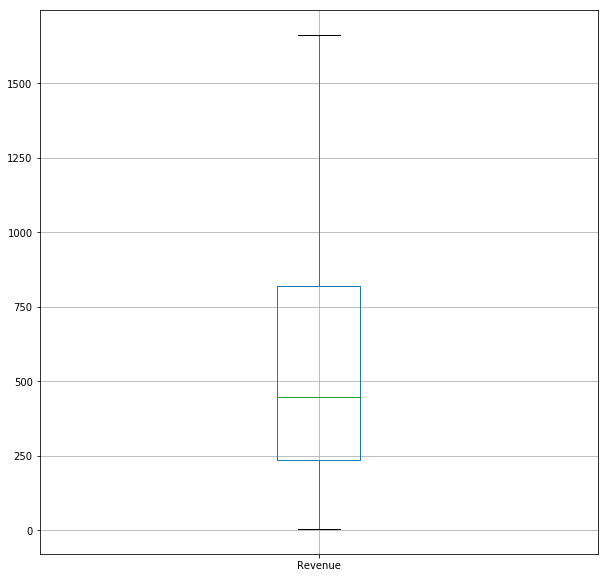

In [23]:
sales_cust_grouped_75_revenue.boxplot(column='Revenue', figsize=(10,10))
plt.show()

<a id='transaction_link'></a>

## Transaction Exploration

In [24]:
#Regroup sales transactions
sales_trans_grouped = data.groupby('InvoiceNo')['Quantity','Revenue'].sum()
sales_trans_grouped['ASP'] = sales_trans_grouped["Revenue"]/ sales_trans_grouped['Quantity']

trans_grouped_75_quantity = sales_trans_grouped.loc[sales_trans_grouped["Quantity"] < sales_trans_grouped.Quantity.quantile(.75)]
trans_grouped_75_revenue = sales_trans_grouped.loc[sales_trans_grouped["Revenue"] < sales_trans_grouped.Revenue.quantile(.75)]

In [25]:
# Look at number of transactions
print('Number of transactions: {}'.format(len(sales_trans_grouped)))
print('Total Revenue: {}'.format(sum(sales_trans_grouped['Revenue'])))
print('Total Units: {}'.format(sum(sales_trans_grouped['Quantity'])))

Number of transactions: 19960
Total Revenue: 10666684.544000056
Total Units: 5588376


In [26]:
sales_trans_quantity_75 = sales_trans_grouped.loc[sales_trans_grouped['Quantity'] < sales_trans_grouped.Quantity.quantile(.75)]
sales_trans_revenue_75 = sales_trans_grouped.loc[(sales_trans_grouped['Revenue'] < sales_trans_grouped.Revenue.quantile(.75)) & (sales_trans_grouped['Revenue'] >0)]

When we focus on sales transactions only that reduces our transaction count from 25,900 to 20,496.  Still a good number of transactions for analysis.  Next let's look at the descriptive statistics for this reduced group.>

In [27]:
sales_trans_grouped.describe()

,Quantity,Revenue,ASP
count,19960.000000,19960.000000,19960.000000
mean,279.978758,534.403033,7.735306
std,955.324779,1780.487648,159.132388
min,1.000000,0.380000,0.060000
25%,70.000000,152.510000,1.424549
50%,151.000000,303.835000,1.946812
75%,296.000000,495.615000,2.816500
max,80995.000000,168469.600000,13541.330000


For sales transactions it looks like the average revenue is 465, with 232 units and ASP of 6.21.  Based on that ASP it looks like most of the items they sell are of a lower dollar value.  The 75% percentile for ASP reinforces that as it's only 2.78.  But based on the max of 13,541 it looks like there are some transactions with individual products that are very highly priced. We'll have ot look for more detail on those higher priced items later and see if they are valid o be included. Next lets look at histograms to see distribution for ASP, Quantity and Revenue.

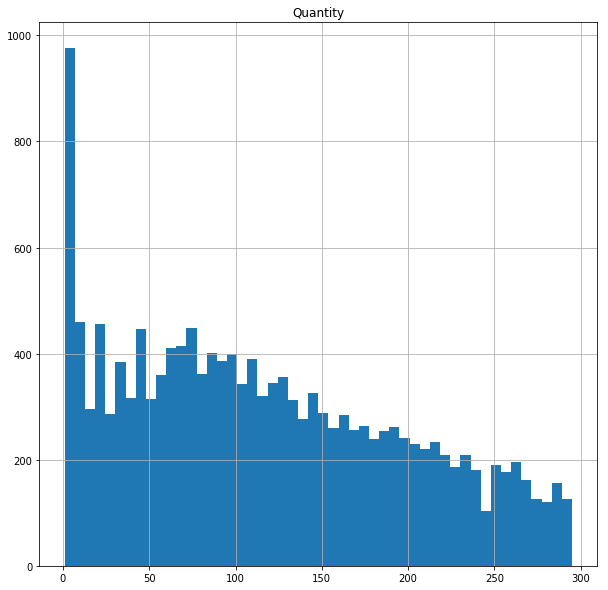

In [28]:
trans_grouped_75_quantity.hist(column='Quantity',bins=50, figsize=(10,10))
plt.show()

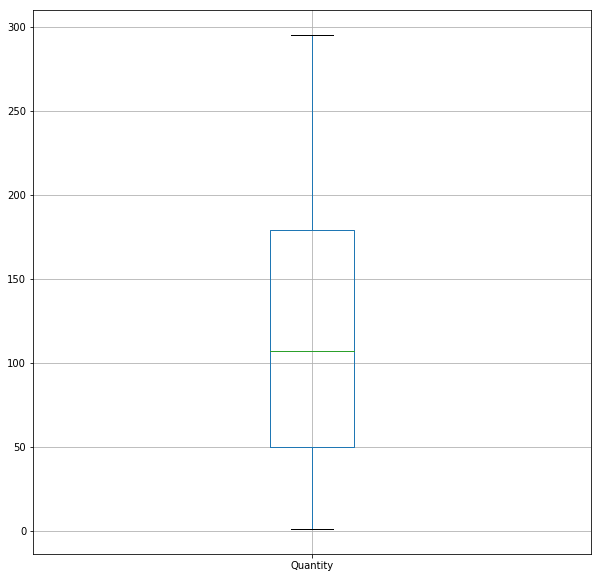

In [29]:
trans_grouped_75_quantity.boxplot(column='Quantity', figsize=(10,10))
plt.show()

The histograms reinforce what we saw with the descriptive statistics, most transactions are at the lower end of Revenue, ASP and Quantity.  Let's look at boxplots for a different view of the distributions of Quantity and Revenue.

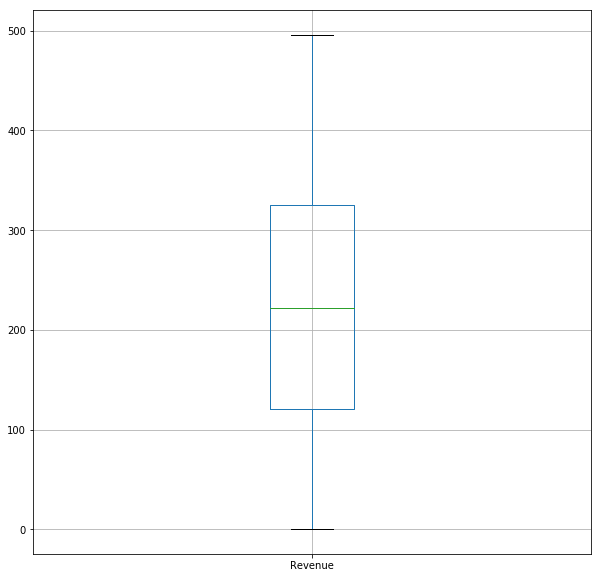

In [30]:
sales_trans_revenue_75.boxplot(column='Revenue', figsize=(10,10))
plt.show()

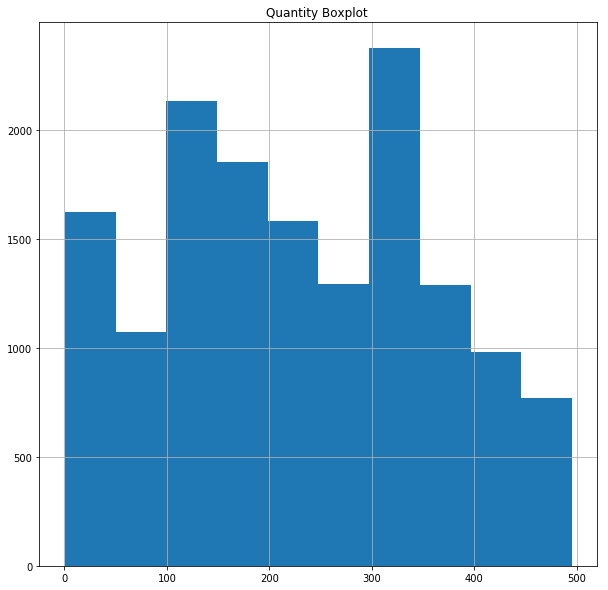

In [31]:
trans_grouped_75_revenue.hist(column='Revenue', figsize=(10,10))
plt.title('Quantity Boxplot ')
plt.show()

The box plots alighn with everything we've seen in regards to individual transactions.  Now that we have a general idea about those, let's look at the data form a customer perspective.
<a id='product_link'></a>

## Product Exploration


To begin the exploration let's look at the data at the product level.  It will be important to learn how many product there are as well as learn about the differences in revenue and quantity of each product.

In [32]:
# Group data by transactions with Revenue and Quantity columns
product_grouped = data.groupby(by='Description')['Quantity','Revenue'].sum()
product_grouped['ASP'] = product_grouped['Revenue'] / product_grouped['Quantity']
print('Number of Products: {}'.format(len(product_grouped)))

Number of Products: 4026


In [33]:
product_grouped.describe()

,Quantity,Revenue,ASP
count,4026.000000,4026.000000,4026.000000
mean,1388.071535,2649.449713,8.122115
std,3465.395806,7815.336619,205.624154
min,1.000000,0.003000,0.001000
25%,56.000000,126.757500,1.025689
50%,358.000000,666.900000,1.969831
75%,1372.750000,2190.140000,3.975347
max,80995.000000,206248.770000,11062.060000


In [47]:
# Top 20 Revenue Products
product_grouped_revenue = product_grouped.sort_values(by="Revenue", ascending=False)
product_grouped_revenue.head(10)

,Quantity,Revenue,ASP
Description,,,
DOTCOM POSTAGE,706,206248.77,292.137068
REGENCY CAKESTAND 3 TIER,13879,174484.74,12.571852
"PAPER CRAFT , LITTLE BIRDIE",80995,168469.60,2.080000
WHITE HANGING HEART T-LIGHT HOLDER,37891,106292.77,2.805225
PARTY BUNTING,18295,99504.33,5.438881
JUMBO BAG RED RETROSPOT,48474,94340.05,1.946199
MEDIUM CERAMIC TOP STORAGE JAR,78033,81700.92,1.047005
Manual,7225,78112.82,10.811463
POSTAGE,3150,78101.88,24.794248


In [45]:
top_10 = product_grouped_revenue.head(10)

In [46]:
top_10

,Quantity,Revenue,ASP
Description,,,
DOTCOM POSTAGE,706,206248.77,292.137068
REGENCY CAKESTAND 3 TIER,13879,174484.74,12.571852
"PAPER CRAFT , LITTLE BIRDIE",80995,168469.60,2.080000
WHITE HANGING HEART T-LIGHT HOLDER,37891,106292.77,2.805225
PARTY BUNTING,18295,99504.33,5.438881
JUMBO BAG RED RETROSPOT,48474,94340.05,1.946199
MEDIUM CERAMIC TOP STORAGE JAR,78033,81700.92,1.047005
Manual,7225,78112.82,10.811463
POSTAGE,3150,78101.88,24.794248


In [43]:
product_grouped_quantity.describe()

,Quantity,Revenue,ASP
count,4026.000000,4026.000000,4026.000000
mean,1388.071535,2649.449713,8.122115
std,3465.395806,7815.336619,205.624154
min,1.000000,0.003000,0.001000
25%,56.000000,126.757500,1.025689
50%,358.000000,666.900000,1.969831
75%,1372.750000,2190.140000,3.975347
max,80995.000000,206248.770000,11062.060000


In [35]:
# Top 10 Quantity Products
product_grouped_quantity = product_grouped.sort_values(by="Quantity", ascending=False)
product_grouped_quantity.head(10)

,Quantity,Revenue,ASP
Description,,,
"PAPER CRAFT , LITTLE BIRDIE",80995,168469.60,2.080000
MEDIUM CERAMIC TOP STORAGE JAR,78033,81700.92,1.047005
WORLD WAR 2 GLIDERS ASSTD DESIGNS,55047,13841.85,0.251455
JUMBO BAG RED RETROSPOT,48474,94340.05,1.946199
WHITE HANGING HEART T-LIGHT HOLDER,37891,106292.77,2.805225
POPCORN HOLDER,36761,34298.87,0.933023
ASSORTED COLOUR BIRD ORNAMENT,36461,59094.93,1.620771
PACK OF 72 RETROSPOT CAKE CASES,36419,21259.10,0.583737
RABBIT NIGHT LIGHT,30788,66964.99,2.175035


In [51]:
top_10 = product_grouped_quantity.head(10).reset_index()

In [62]:
top_10 = top_10.sort_values(by='Quantity')

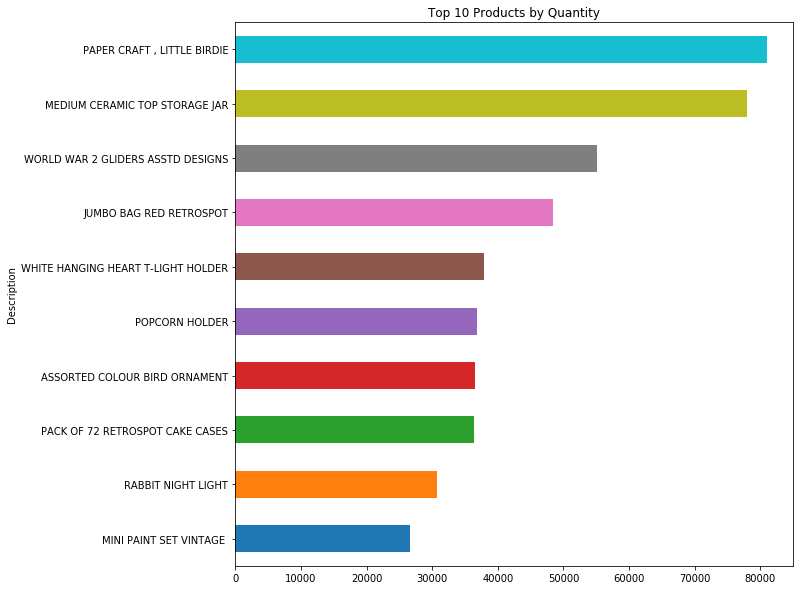

In [68]:
top_10.plot(x='Description', y='Quantity', kind='barh', figsize=(10,10), legend=False)
plt.title('Top 10 Products by Quantity')
plt.show()

In [36]:
product_grouped.describe()

,Quantity,Revenue,ASP
count,4026.000000,4026.000000,4026.000000
mean,1388.071535,2649.449713,8.122115
std,3465.395806,7815.336619,205.624154
min,1.000000,0.003000,0.001000
25%,56.000000,126.757500,1.025689
50%,358.000000,666.900000,1.969831
75%,1372.750000,2190.140000,3.975347
max,80995.000000,206248.770000,11062.060000


In [37]:
# Look at 75th percentile of product to exclude large outliers
product_grouped_75_quantity = product_grouped.loc[product_grouped["Quantity"] < product_grouped.Quantity.quantile(.75)]
product_grouped_75_revenue = product_grouped.loc[product_grouped["Revenue"] < product_grouped.Revenue.quantile(.75)]

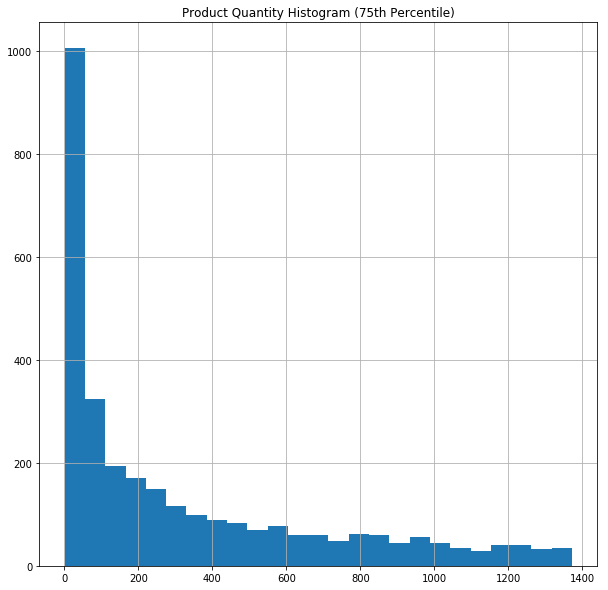

In [38]:
product_grouped_75_quantity.hist(column='Quantity', bins=25, figsize=(10,10))
plt.title('Product Quantity Histogram (75th Percentile)')
plt.show()

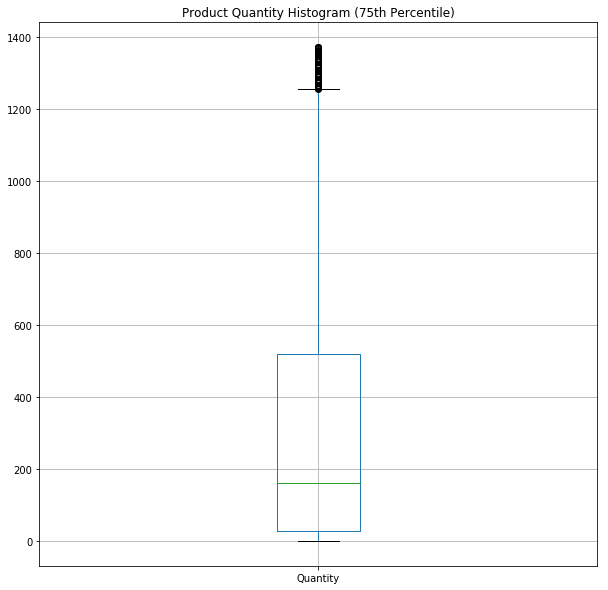

In [39]:
product_grouped_75_quantity.boxplot(column='Quantity', figsize=(10,10))
plt.title('Product Quantity Histogram (75th Percentile)')
plt.show()

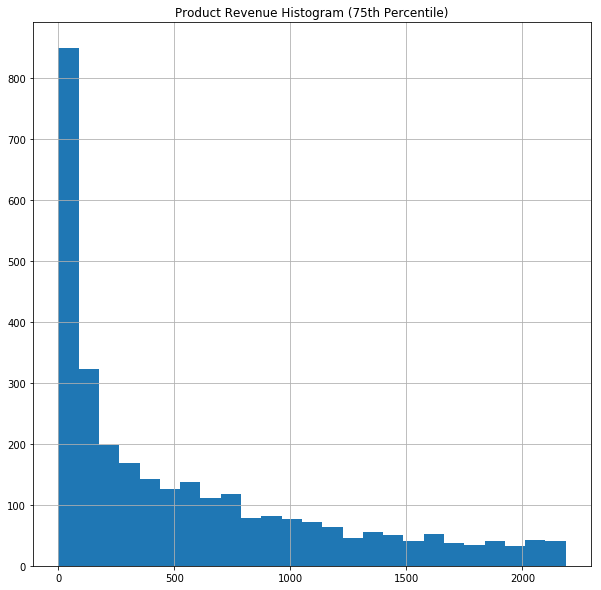

In [40]:
product_grouped_75_revenue.hist(column='Revenue', bins=25, figsize=(10,10))
plt.title('Product Revenue Histogram (75th Percentile)')
plt.show()

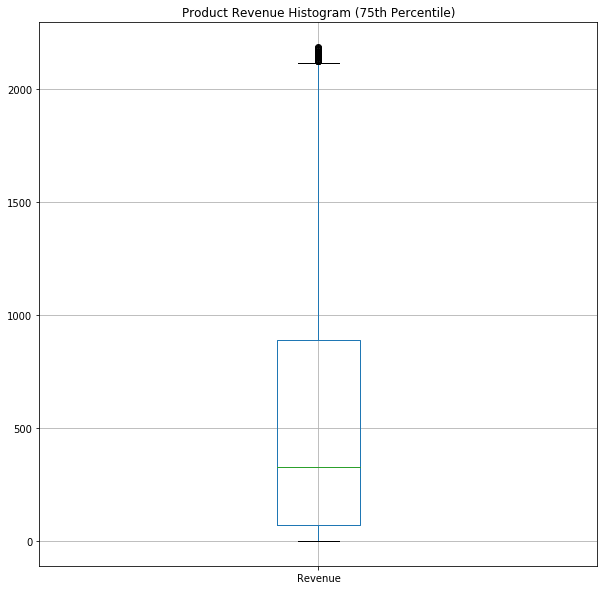

In [41]:
product_grouped_75_revenue.boxplot(column='Revenue', figsize=(10,10))
plt.title('Product Revenue Histogram (75th Percentile)')
plt.show()